# MathFound - EXERCISE 3 - MLS FOR CURVES, MESHES AND IMAGES
## General Rules

**Plagiarism note.** Copying code (either from other students or from external sources) is strictly prohibited! We will be using automatic anti-plagiarism tools, and any violation of this rule will lead to expulsion from the class.

Late submissions will not be accepted, except in case of serious illness or emergency. In that case please notify the assistants and provide a relevant medical certificate.

**Software.** All exercises of this course use Python.

**What to hand in.** Upload a .zip file of your solution in Moodle. The file must be called `MATHFOUND21-3-firstname-familyname.zip`. The `.zip` file MUST contain the following data inside:

* A jupyter notebook with the solution to the exercise and a description of what you implemented and comments/explanations on your results.

**OR** 

* The solution in `.py` format and a `readme.pdf` file containing a description of what you’ve implemented and instructions for running it, as well as explanations/comments on your results.

**Grading** This homework is 8.3% of your final grade. Your submission will be graded according to the quality of the images produced by your program, the conformance of your program to the expected behaviour of the assignment, and your understanding of the underlying techniques used in the assignment. The submitted code must produce exactly the same images included in your submission.

## Goal of this exercise

In this exercise you will apply what you learned about the Moving Least Squares (MLS) method to curves, meshes and images. You will read and implement parts of research papers that used MLS.

## Image deformation using MLS

The first task of this assignment is to write code which deforms images based on moving least squares as presented in the paper "Image Deformation using Moving Least Squares" by Schaefer et al. (provided with the exercise). In this paper, the authors propose a method to smoothly deform images using different kinds of transformations and allow the user to manipulate sets of points and segments to specify the deformations. For this exercise you will only focus on image deformations using sets of points.

Write a program which takes as input an image, some input and out control points and performs the deformation. The algorithm should follow the description from the paper. The three kinds of transformation, i.e. affine, similarity and rigid transformations should be supported by your program. Please note that we don't ask for an interactive application so that you don't need to worry about making the code fast (precomputation of some terms, approximation of the image by a grid), but you can do it if you wish.

Some pointers to help with your implementation:

* Read section 2 of the paper to understand the types of transformations you need to apply.
* Implement backwards warping to avoid artifacts.
* You can use `meshgrid` (in `numpy`) and `griddata` (in `scipy`) functions to implement the warping process

Your result should ressemble the following

![image.png](images/deformed_gingerbread.png)

### Required output

* **Code that deforms images according to user input using all three methods described above (affine, similarity and rigid).**
* **Representative image results of the gingerbread man (provided with the exercise) and at least one more image of your choice.**

### Selecting the control points interactively

If you want to create an interactive version of your image deformation code, you can look into using `ipywidgets` which allows you to set a callback function when the user clicks on the displayed image (with matplotlib). Any other solution is also fine (for example if you want to make a standalone `.py` for that part :).

In [2]:
# Importing useful libraries
import matplotlib.pyplot as plt
import numpy as np

### Answer 

As explained in Section 4 of the paper we need to define a grid in order to compute efficiently the deformation we will use a grid.

In [2]:
alpha= 1.0
p=np.array([[[163.5, 53.7]],
[[ 171.8 , 186.0]],
[[177.3, 258.1]],
[[112.8, 366.4]],
[[248.3, 370.7]],
[[39.6, 158.7]],
[[271.3, 152.1]],
[[335.8, 155.4]]]) # input points

q= np.array([[[163.5, 53.7 ]],
 [[171.8, 186.0 ]],
[[162.0, 271.3]],
[[ 148.9, 362.0]],
[[275.7, 371.8]],
[[10.0, 285.5]],
[[273.5, 110.6]],
[[332.5, 62.5]]]) # output points after deformation


In [8]:
def  w_(i,v):
    
    return 1/np.linalg.norm(p[i]-v)**(2*alpha)

def vect_star(p,v):
    n=len(p)
    num=0; denom=0
    for i in range(n):
        w=w_(i,v)
        num+=w*p[i]
        denom+=w
    return num/denom


In [3]:
# Affine deformation
def f_a(v,p,q):
    n=len(p)
    p,q=p.reshape(n,1,2),q.reshape(n,1,2)
    p_star= vect_star(p,v)   # p*
    q_star= vect_star(q,v)      # q*
    result=[q_star]
    Mat_inv=np.linalg.inv(np.sum( [np.dot((p[i]- p_star).T,w_(i,v)*(p[i]- p_star) ) for i in range(n)],0)) 
    for j in range(n):
        Aj=np.dot(np.dot(v-p_star,    Mat_inv ),
                 w_(j,v)*(p[j]-p_star).T)
        
        result.append(np.dot(Aj, q[j]-q_star))
    return np.sum(result,0)[0]


In [4]:
# the orthogonal function
def orthg(q):
    return np.array([[-q[0][1], q[0][0]]])

In [5]:
# similarity deformation
def f_s(v,p,q):
    n=len(p)
    p,q=p.reshape(n,1,2),q.reshape(n,1,2)
    p_star= vect_star(p,v)   # p*
    q_star= vect_star(q,v)      # q*
    result=[] ; mu=0
    for j in range(n):
        p_hat=p[j]- p_star
        q_hat= q[j]-q_star
        mu+=w_(j,v)*(np.dot(p_hat,p_hat.T)[0][0])
        Aj=np.dot(w_(j,v),np.dot(np.array([p_hat,-orthg(p_hat)]).reshape(2,2),(np.array([v-p_star,-orthg(v-p_star)]).T).reshape(2,2) ) )
        
        result.append(np.dot(q_hat,Aj))
    return (np.sum(result,0)/mu + q_star)[0]
        

In [6]:
# rigid deformation 
def f_r(v,p,q):
    n=len(p)
    p,q=p.reshape(n,1,2),q.reshape(n,1,2)
    p_star= vect_star(p,v)   # p*
    q_star= vect_star(q,v)      # q*
    fr_vec=[] ; mu=0
    for j in range(n):
        p_hat=p[j]- p_star
        q_hat= q[j]-q_star
        Aj=np.dot(w_(j,v),np.dot(np.array([p_hat,-orthg(p_hat)]).reshape(2,2),(np.array([v-p_star,-orthg(v-p_star)]).T).reshape(2,2) ) )
        fr_vec.append(np.dot(q_hat,Aj))
    fr_vec=np.sum(fr_vec,0)
    fr_vec=np.array(fr_vec)
    return (np.linalg.norm(v-p_star)*fr_vec/np.linalg.norm(fr_vec)  +q_star)[0]
    

In [13]:
f_a(np.array([1,1]),p,q)

array([-34.41155569, 134.93180352])

In [14]:
f_r(np.array([1,1]),p,q)

array([-51.94082161,  91.10524605])

In [15]:
print(np.array([1,1]).shape)

(2,)


In [19]:
# reading the image
ginger=plt.imread('data/ginger.png')

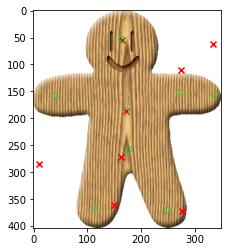

In [20]:
plt.scatter(q[:,:,0],q[:,:,1],marker='x',color='red')
plt.scatter(p[:,:,0],p[:,:,1],marker='o',color='limegreen',facecolors='none')
plt.imshow(ginger)

In [48]:
def deformed_image(function,img,p,q):
    # Inverting p and q
    p,q=q,p
    
    (height, width,_) = img.shape
    
    # getting a grid on the entire image pixel per pixel
    x=np.linspace(0,width-1,width).astype(np.int32) 
    y=np.linspace(0,height-1,height).astype(np.int32)
    
    
    vertices=np.array([ np.array([i,j]) for j in y for i in x]   )
    # creating the output image
    new_img=np.zeros_like(img)
    
    for i in range (len(vertices)):
        # Apply the deformation with the function for each vertices
        new_vertices= function(vertices[i],p,q)
        xx= new_vertices[0];yy=new_vertices[1] 
    
        if 0<=xx< width and 0<=yy< height:  # check if the result is in the limits of the image dimension
            
            new_img[vertices[i][1],vertices[i][0]]=img[int(yy)][int(xx)] # xx and yy are shifted because of the image shape
        else:
            new_img[vertices[i][1],vertices[i][0]]=[ 0, 0, 0]
     
    
    return new_img

In [49]:
def plot_deformation_results(img,functions,p,q): # functions is a dictionary of functions with the name and the expression
    
    nb_functions=len(functions)
    name=list(functions.keys())
    f=list(functions.values())
    
    #Plotting the original image
    fig = plt.figure(figsize=(25,18))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    ax0 = fig.add_subplot(2,2,1)
    ax0.scatter(q[:,:,0],q[:,:,1],marker='x',color='red')
    ax0.scatter(p[:,:,0],p[:,:,1],marker='o',color='limegreen',facecolors='none')
    ax0.imshow(img)
    ax0.set_title('Original image')
    
    #Plotting the deformed images
    for i in range(nb_functions):
        ax1 = fig.add_subplot(2,2,i+2)
        ax1.scatter(q[:,:,0],q[:,:,1],marker='x',color='red')
        ax1.scatter(p[:,:,0],p[:,:,1],marker='o',color='limegreen',facecolors='none')
        ax1.imshow(deformed_image(f[i],img,p,q))
        ax1.set_title(name[i])
    

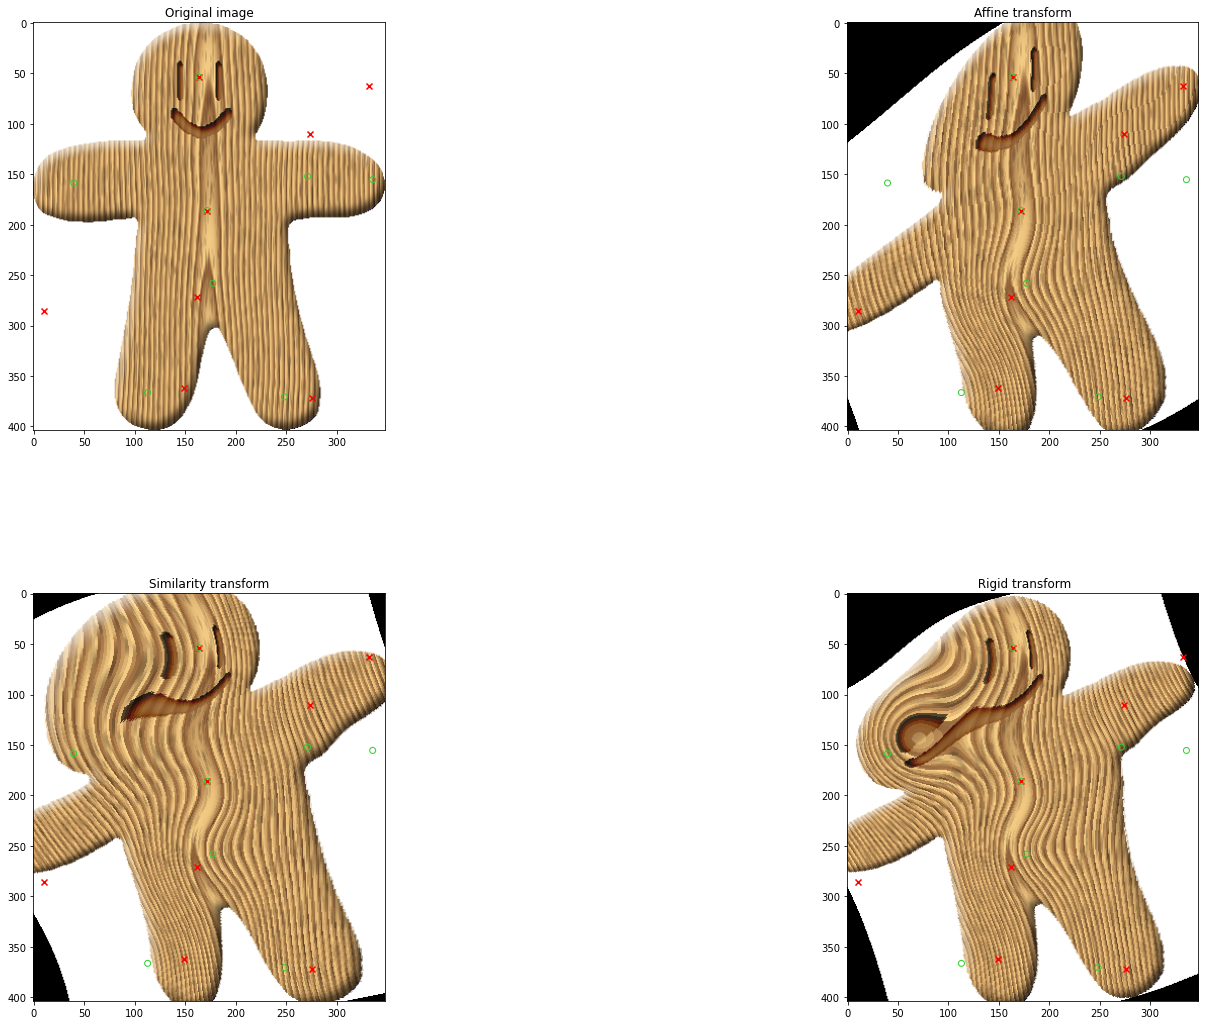

In [50]:
functions={'Affine transform':f_a ,'Similarity transform': f_s,' Rigid transform': f_r}
plot_deformation_results(ginger,functions,p,q)

##### Test on the chess 

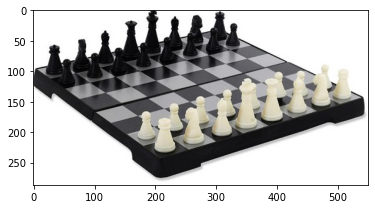

In [28]:
chess=plt.imread('data/chess.jpg')
plt.imshow(chess)

plt.show()

In [34]:
handle_points=np.array([[[3.7830005768806814, 94.59778225806457]], [[96.92816186720326, 165.56552419354838]],
                        [[205.59751670591294, 270.9082661290322]], [[358.6217102543, 196.6139112903226]], 
                        [[539.3676779962354, 144.49697580645164]], [[412.9563876736549, 81.29133064516134]], 
                        [[304.2870328349452, 23.630040322580726]], [[172.3313876736549, 55.787298387096826]]])

output_points=np.array([[[132.4120328349452, 10.323588709677495]], [[127.97654896397744, 142.27923387096774]],
                        [[125.75880702849356, 270.9082661290322]], [[320.9200973510742, 259.81955645161287]],
                        [[496.1217102543, 254.2752016129032]], [[482.81525864139684, 128.9727822580645]],
                        [[475.0531618672033, 12.541330645161338]], [[316.4846134801065, 13.650201612903288]]])

In [30]:
def tower_out_points(points):
    out=[]
    for i in range(len(points)):
        out.append([points[i][0]+(points[i][1])**(1/2),points[i][1]])
    return np.array(out)
output_points=tower_out_points(handle_points)

In [31]:
print(len(handle_points))

8


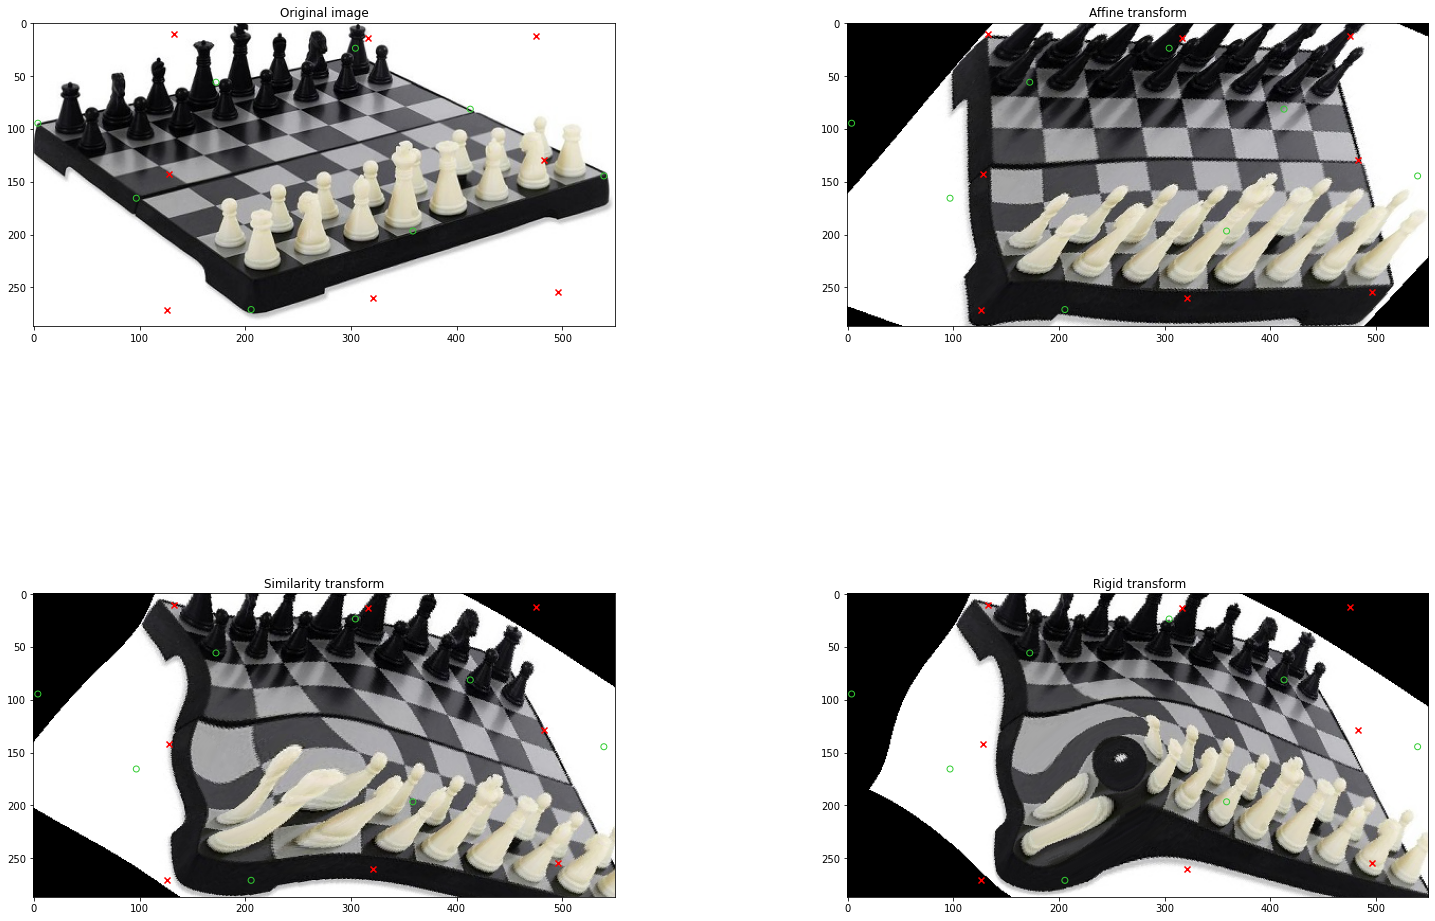

In [51]:
chess_functions={'Affine transform':f_a,'Similarity transform': f_s,' Rigid transform': f_r}
plot_deformation_results(chess,chess_functions,handle_points,output_points)

## Curve and Surface Reconstruction Using MLS

As described in the lectures, moving least squares (MLS) can be used to approximate a function given samples from that function at sample points. In this exercise, we will utilize this method to reconstruct curves and smooth meshes. We provide a few example datasets.

### Implicit MLS Surfaces

Given some samples points and attributes (i.e. normals, colors), we seek to find a function $f(\mathbf{x}) : \mathbb{R}^2 \text{ or } \mathbb{R}^3 \rightarrow \mathbb{R}$ such that the curve or surface is given by $\mathcal{S} = \{ \mathbf{x} \vert f(\mathbf{x}) = 0, \nabla f(\mathbf{x}) \neq \mathbf{0} \}$

### Curves derivation

MLS based surfaces can be computed by considering different degrees for the local approximations and constraints, as described in the lectures. The first part of the exercise is to derive on paper one of the simplest definitions for MLS based surfaces. For this task, we assume that the locally fit polynomial consists of a single constant term, $f(\mathbf{x}) = c_0$,

$$
\underset{c_0}{\operatorname{argmin}}\sum_i \phi_i(\mathbf{x})(c_0 - f_i(\mathbf{x}))^2
$$

Using the following local functional approximation

$$
f_i(\mathbf{x}) = \mathbf{n_i}^T(\mathbf{x} - \mathbf{x_i})
$$

**derive the closed-form expression for the resulting implicit function** $f(\mathbf{x})$.

Hint: it is a weighted least squares problem for the scalar $c_0$, and hence reduces to a simple normalized average.

### Answer

Let's derive the closed-form expression for the resulting implicit function  $f(x)$ <br>
We want to minimize the following expression $\sum_{i}\phi_i(x)(c_0-f_i(x))^2$ <br>
$$\frac{\partial} {\partial c_0} \left( \sum_{i}\phi_i(x)(c_0-f_i(x))^2 \right) =  \sum_{i}\phi_i(x) \frac{\partial} {\partial c_0} \left[(  c_0-f_i(x))^2 \right]  = 2\sum_{i}\phi_i(x)(c_0-f_i(x)) \\ $$
$$\frac{\partial} {\partial c_0} \left( \sum_{i}\phi_i(x)(c_0-f_i(x))^2 \right) = 0 \; \implies \sum_{i}\phi_i(x)c_0(x)=\sum_{i}\phi_i(x) f_i(x)$$
Locally, $c_0(x) = f(x)$ <br>
Hence, $$f(x)=\frac{\sum_{i}\phi_i(x) f_i(x)}{\sum_{i}\phi_i(x)}$$

### Curves plotting

Evaluate the derived $f(\mathbf{x})$ for the given example point sets with 2D points and normals, on a regular grid. For the definition of $\phi$, you may use a Gaussian of a chosen $\sigma$ such that $\phi(r) = e^{-r^2/\sigma^2}$. Initialize a matrix representing the grid. Then, for each grid center, evaluate the function $f$ and store the value at the entry of the matrix corresponding to that grid. Finally, plot this matrix as a heatmap or similar, overlaid with the sample points in the same image (as shown below).

![image.png](images/plots2.2.png)

Generate **a few images with different $\sigma$ values to illustrate how it affects the approximation and discuss your results**. You can see the reconstructed curve by observing the values of $f$ close to zero. How is the value of $\sigma$ influencing the results ?

#### Implementation hints

* You can use `imshow` from `matplotlib` to visualize the matrix
* If the plotted $f(\mathbf{x})$ looks too smooth, try decreasing $\sigma$. Similarly, if you get discountinuous $f(\mathbf{x})$, try increasing $\sigma$.
* You can use numpy to load the data:

### Answer

We can assume that f will be defined in $[-2,2]^2$. <br>
Beside, $$\phi_i(x)=\phi(||x-x_i||)=e^{-\frac{{||x-x_i||}^2}{\sigma^2}}$$
$x_i$ are given by the points of the curve and $n_i$ are given by the normals.<br>
With the previous expression we can easily compute f for a given x: 
$$f(x)=\frac{\sum_{i=1}^{n_b} e^{-\frac{{||x-x_i||}^2}{\sigma^2}} n_i^T(x-x_i)}{\sum_{i=1}^{n_b} e^{-\frac{{||x-x_i||}^2}{\sigma^2}}}$$
$n_b$ is the number of points

In [9]:
# sigma choice
sigma=0.5

In [6]:
def f(x,points,normals,sigma):
    nb=len(points)
    numerator=0
    denominator=0
    for i in range(nb):
        diff=x-points[i]
        exp_term=np.exp(-(np.linalg.norm(diff)/sigma)**2) 
        denominator+= exp_term
        numerator+=exp_term*np.dot(normals[i],diff)
    return numerator/denominator

In [11]:
# we can take N = 1000 for the size of the matrix
N=100
def grid_f(points,normals,sigma):
    
    vx=np.linspace(-2,2,N+1) # possibles values of  x in order
    vy=np.linspace(2,-2,N+1) # possibles values of  y in order
    # matrix initialisation
    M=np.zeros([N,N])
    # matrix update
    for i in range(N):
        for j in range(N):
            grid_center=np.array([(vx[j+1]+vx[j])/2,(vy[i+1]+vy[i])/2]) # center of the grid
            M[i,j]= f(grid_center,points,normals,sigma)
    return M

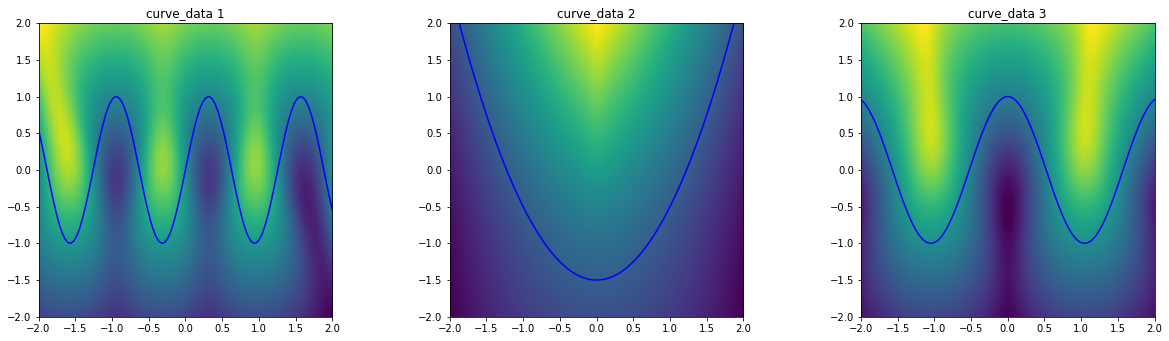

In [74]:
# Printing the image and the curves
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1,4):
    curve_data = np.load('data/curve_data'+str(i)+'.npz')
    points = curve_data['points']
    normals = curve_data['normals']
    ax=fig.add_subplot(1,3,i)
    plt.xlim([-2,2])
    plt.ylim([-2,2])
    ax.imshow(grid_f(points,normals,sigma),extent=[-2,2,-2,2],)
    ax.plot(points[:,0], points[:,1],color='blue')
    ax.set_title("curve_data "+str(i))
    
plt.show()


### Smoothing meshes

Load the vertices and normals of the provided meshes. These will serve as the sample points and normals. Then, project each vertex coordinate $\mathbf{v}$ of the mesh by $\mathbf{v}′ = \mathbf{v} − f(\mathbf{x})\nabla f(\mathbf{x})$, where $f(\mathbf{x})$ is the same as in the first task. This will give you new smoothed coordinates $\mathbf{v}′$ of the mesh vertices. The expression for $\nabla f(\mathbf{x})$ can be derived on paper - use the chain rule, the result is a long formula :). The answer is not the same as the one in the attached paper (but part of it is similar). Apply this smoothing a few times, obtaining a result similar to this

![image.png](images/cat_and_smoothed.png)

To load, modify and display meshes, you can use the `trimesh` package (`pip install --user trimesh`). Here's a quick example to load and visualize the stanford bunny mesh 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import trimesh

In [33]:
# To load a mesh
mesh = trimesh.load_mesh('data/cat.off', process=False)

# To access the vertices, faces and normals
vertices = mesh.vertices
faces = mesh.faces
normals = mesh.vertex_normals

# To visualize a mesh
mesh.show()

In [5]:
print(len(vertices))

366


In [6]:
vertices[1]

TrackedArray([ -1., -60.,  10.])

#### Hints

* The expression for $\nabla f(\mathbf{x})$ can be easily derived on paper. If you wish, you may confirm your expression by comparing it to the expression in Section 4.3 of the paper "Feature Preserving Point Set Surfaces based on Non-Linear Kernel Regression" provided next to this notebook.
* The function $f(\mathbf{x})$ is always computed by using the initial positions and normals of the vertices, even if you do multiple iterations of projections.
* As in the previous exercise, try changing $\sigma$ to see its smoothing effect.

#### Required outputs

* **The derivation of $\nabla f(\mathbf{x})$**
* **The mesh smoothing code**
* **Screenshots of results produced by your code for both meshes**

### Answer - derivation

$\nabla f(x)= \nabla_x \left( \frac{\sum_{i}\phi_i(x) f_i(x)}{\sum_{i}\phi_i(x)} \right)$ <br>
$\nabla f(x)= \left( \sum_i \nabla(\phi_i(x))f_i(x)+\phi_i(x)\nabla(f_i(x)) \right) {\left( \sum_{i}\phi_i(x) \right)}^{-1}    - \left(\sum_i\phi_i(x)f_i(x)\right)  \left(\sum_i \nabla(\phi_i(x)) \right) {\left( \sum_{i}\phi_i(x) \right)}^{-2}$ <br><br>
Let's compute now $\nabla(\phi_i(x))$ and $\nabla(f_i(x))$ <br>
$\nabla(\phi_i(x))=\nabla \left(e^{-\frac{{||x-x_i||}^2}{\sigma^2}} \right)= -\frac{2(x-xi)^T\phi_i(x)}{\sigma^2}$<br>
$\nabla(f_i(x))=\nabla \left( n_i^T(x-x_i)\right)=n_i^T$<br>
We can then rewrite $\nabla f(x)$ as follow: <br>
$$\nabla f(x)={\left [ \sum_i\phi_i(x)\right ]}^{-1} \left [ \sum_i \phi_i(x) \left ( n_i^T+\frac{2}{\sigma^2}(x-x_i)^T(f(x)-f_i(x)) \right ) \right ]$$

### Answer - smoothing code

In [3]:
def gradient_f(x,points,normals,sigma):
    nb=len(points)
    numerator=0
    denominator=0
    f_x=f(x,points,normals,sigma)
    for i in range(nb):
        diff=x-points[i]
        # The expressions of normals and x are supposed to already be the transposed
        sum_term=normals[i]+2*(x-points[i])*(f_x-np.dot(normals[i],diff))/(sigma**2)    
        exp_term=np.exp(-(np.linalg.norm(diff)/sigma)**2) 
        denominator+= exp_term
        numerator+=exp_term*sum_term
    return numerator/denominator

In [4]:
def f_times_gradient_f(x,points,normals,sigma):
    nb=len(points)
    numerator=0
    denominator=0
    f_x=f(x,points,normals,sigma)
    for i in range(nb):
        diff=x-points[i]
        # The expressions of normals and x are supposed to already be the transposed
        sum_term=normals[i]+2*(x-points[i])*(f_x-np.dot(normals[i],diff))/(sigma**2)    
        exp_term=np.exp(-(np.linalg.norm(diff)/sigma)**2) 
        denominator+= exp_term
        numerator+=exp_term*sum_term
    return (numerator/denominator)*f_x

In [52]:
def new_vertices(normals,vertices,sigma,max_iter):
    new_vert=vertices
    initial_points=vertices
    m=0
    while m < max_iter:
        new_vert= [ new_vert[i]-f_times_gradient_f(new_vert[i],initial_points,normals,sigma) for i in range(len(new_vert))] 
        m+=1
    return new_vert

In [56]:
sigma=100

In [57]:
new_vert=new_vertices(normals,vertices,sigma,3)

In [58]:
new_mesh=trimesh.Trimesh(vertex_normals=normals,vertices=new_vert,faces=faces)
new_mesh.show()

For $\sigma \leq 15$, we do not see a real noticeable change even after many iterations because $f(x)$ is close to zero.
The higher sigma is, and the better the smoothing is and It requires less iterations before convergence. Here I used $\sigma= 100$ with only 3 iterations.

Here is the final result after smoothing the cat mesh


![cat initial and final mesh](data/cat_initial_final.png)

##### Bunny

In [59]:
# To load a mesh
mesh = trimesh.load_mesh('data/bunny.off', process=False)

# To access the vertices, faces and normals
vertices = mesh.vertices
faces = mesh.faces
normals = mesh.vertex_normals

# To visualize a mesh
mesh.show() 

In [85]:
sigma=0.1
new_vert=new_vertices(normals,vertices,sigma,2)

In [82]:
f_times_gradient_f(vertices[1],vertices,normals,0.1)

TrackedArray([-0.00241975,  0.00801478, -0.00506884])

In [75]:
print(vertices[0])

[0.007665 0.037204 0.034641]


In [86]:
new_mesh=trimesh.Trimesh(vertex_normals=normals,vertices=new_vert,faces=faces)
new_mesh.show()

For  $\sigma > 1$ , we do not see a real noticeable change even after many iterations because  𝑓(𝑥)  is close to zero.Indeed the vertices coordinates are around $10^{-2}$ and for $\sigma > 1$ the $f(x) \nabla f(x)$ vectors coordinates are around $10^{-6}$. However, for $\sigma  < 0.5$,  $f(x) \nabla f(x)$ vectors coordinates are closer to $10^{-2}$ and we can get a noticeable change in the new vertices. Here I used $\sigma= 0.1$ with only 3 iterations.

Here is the final result after smoothing the cat mesh


![bunny initial and final mesh](data/bunny_initial_final.png)